1.数据准备

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt, find_peaks
from utils.dataset_utils import LoadDataset_HAR 
# 示例：生成时间序列数据及加载 HAR 数据
# ts_data = generate_sampled_time_series(batch_size=3, num_dimensions=2, sequence_length=512, fs=10.0)
X_all, y_all, X_test, y_test, X_fed, y_fed = LoadDataset_HAR(1, 0.1)
har_data = X_all
print(type(har_data))
print("Total samples in X_all:", len(X_all))

/mnt/data/user_liangzhiyu/envs/fedcsl/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/mnt/data/user_liangzhiyu/envs/fedcsl/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


[5 1 1 ... 0 4 0]
[   5   18   21 ... 5831 5862 5868]
<class 'numpy.ndarray'>
Total samples in X_all: 5881


/mnt/data/user_liangzhiyu/lixiongfei/CSL-main/algoutils/utils/dataset_utils.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("./HAR/train.pt")
/mnt/data/us

2. 原始数据可视化

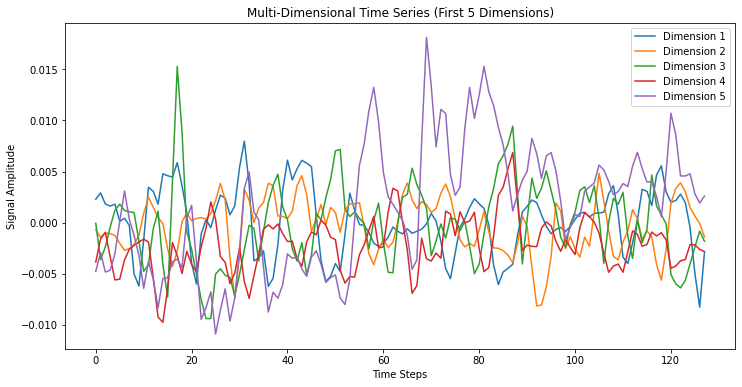

In [2]:
# 选择某个样本进行可视化
sample_idx = 0  # 选择第 0 个样本
sample_data = har_data[sample_idx]  # 形状应为 (K, L) -> (num_dimensions, sequence_length)

# 需要转置为 (sequence_length, num_dimensions) 以便正确绘制
sample_data = sample_data.T  # 转置为 (L, K)

# 设置参数
k = min(5, sample_data.shape[1])  # 显示前 k 维度
time_steps = np.arange(sample_data.shape[0])  # 生成时间轴

# 绘制时序数据
plt.figure(figsize=(12, 6))
for i in range(k):
    plt.plot(time_steps, sample_data[:, i], label=f"Dimension {i+1}")

plt.xlabel("Time Steps")
plt.ylabel("Signal Amplitude")
plt.title(f"Multi-Dimensional Time Series (First {k} Dimensions)")
plt.legend()
plt.show()

3. 个性化算法设计

3.1 STFT 短时傅里叶变换

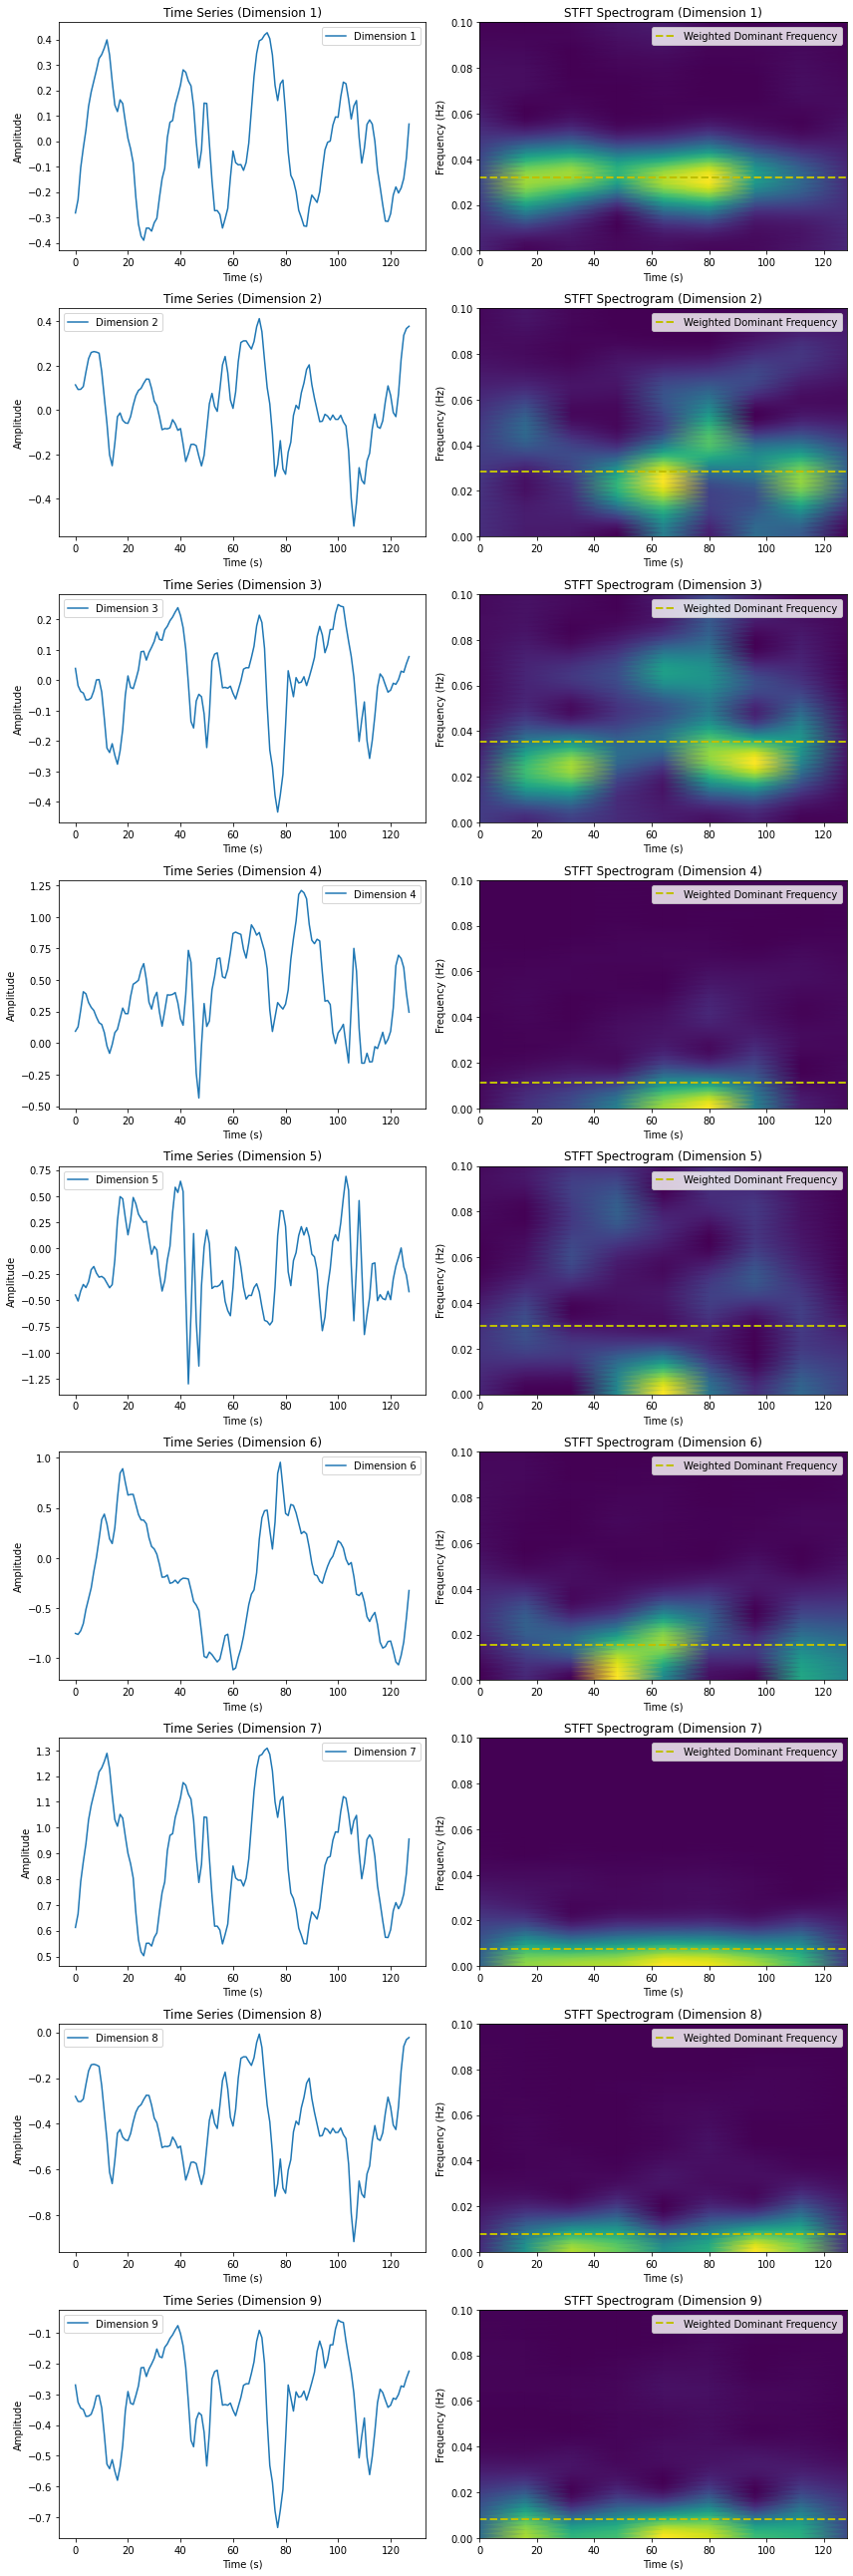

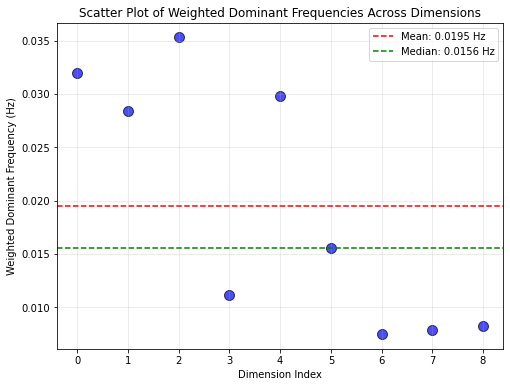

Mean Weighted Dominant Frequency: 0.0195 Hz
Median Weighted Dominant Frequency: 0.0156 Hz
Standard Deviation: 0.0110 Hz
Dimension 1: Frequency = 31.2538 Hz, Scores = [1.44188538e-01 3.69750462e-01 3.48812651e-01 1.21054587e-01
 1.54552413e-02 7.25898414e-04 1.25424224e-05 7.97246309e-08]
Dimension 2: Frequency = 35.2352 Hz, Scores = [8.66754443e-02 3.03360648e-01 3.90596124e-01 1.85012952e-01
 3.22390216e-02 2.06665077e-03 4.87368943e-05 4.22818642e-07]
Dimension 3: Frequency = 28.3351 Hz, Scores = [1.98295507e-01 4.04817986e-01 3.04027062e-01 8.39982436e-02
 8.53755834e-03 3.19229253e-04 4.39113914e-06 2.22206742e-08]
Dimension 4: Frequency = 89.4347 Hz, Scores = [6.96156446e-09 1.68158598e-06 1.49429667e-04 4.88494967e-03
 5.87474308e-02 2.59910115e-01 4.23022046e-01 2.53284341e-01]
Dimension 5: Frequency = 33.5100 Hz, Scores = [1.09239548e-01 3.34123600e-01 3.75958517e-01 1.55624590e-01
 2.36985641e-02 1.32761259e-03 2.73606373e-05 2.07437168e-07]
Dimension 6: Frequency = 64.1883 Hz

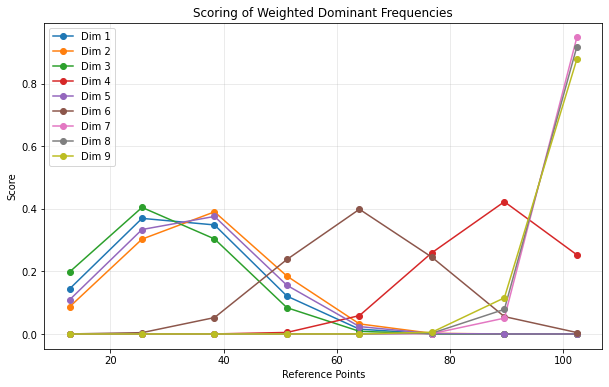

In [3]:
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt

# 选择样本并转置数据
sample_idx = 1  # 选择样本
sample_data = har_data[sample_idx].T  # 转置为 (L, K)
L, K = sample_data.shape  # L: 时间步数, K: 维度数

# 采样率
fs = 1  

# STFT 参数
window_size = max(4, L // 2)  
n_fft = 8 * window_size  
hop_size = window_size // 4  

# 选择前 k 维度
k = min(9, K)  
time_steps = np.arange(L) / fs  

# 创建子图
fig, axes = plt.subplots(k, 2, figsize=(12, 4 * k))

sum_list = []
for i in range(k):
    ax_time = axes[i, 0]
    ax_time.plot(time_steps, sample_data[:, i], label=f"Dimension {i+1}")
    ax_time.set_xlabel("Time (s)")
    ax_time.set_ylabel("Amplitude")
    ax_time.set_title(f"Time Series (Dimension {i+1})")
    ax_time.legend()

    # 计算 STFT
    f, t_stft, Zxx = stft(sample_data[:, i], fs=fs, nperseg=window_size, noverlap=window_size - hop_size, nfft=n_fft)
    
    # 计算功率谱
    power_spectrum = np.abs(Zxx) ** 2

    # **找到最亮区域**（功率最大的前 5%）
    threshold = np.percentile(power_spectrum, 95)  # 取前 5% 最高能量
    bright_region = power_spectrum >= threshold  # 标记高功率点

    # **计算加权中心频率**
    if np.sum(bright_region) > 0:
        weighted_freq = np.sum(f[:, None] * power_spectrum * bright_region) / np.sum(power_spectrum * bright_region)
    else:
        weighted_freq = 0  # 防止除零

    sum_list.append(weighted_freq)  

    # 画 STFT 频谱图
    ax_stft = axes[i, 1]
    ax_stft.pcolormesh(t_stft, f, power_spectrum, shading='gouraud')
    ax_stft.axhline(weighted_freq, color='y', linestyle='--', linewidth=2, label="Weighted Dominant Frequency")

    ax_stft.set_xlabel("Time (s)")
    ax_stft.set_ylabel("Frequency (Hz)")
    ax_stft.set_title(f"STFT Spectrogram (Dimension {i+1})")
    ax_stft.set_ylim(0, 0.1)  
    ax_stft.legend()

plt.tight_layout()
plt.show()

# **对 sum_list 进行统计分析并绘制散点图** [[1]][[3]]
# 将 sum_list 转换为 NumPy 数组以便分析
sum_array = np.array(sum_list)

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(range(len(sum_array)), sum_array, c='blue', alpha=0.7, edgecolor='k', s=100)
plt.axhline(np.mean(sum_array), color='red', linestyle='--', label=f"Mean: {np.mean(sum_array):.4f} Hz")
plt.axhline(np.median(sum_array), color='green', linestyle='--', label=f"Median: {np.median(sum_array):.4f} Hz")

# 添加统计信息
plt.xlabel("Dimension Index")
plt.ylabel("Weighted Dominant Frequency (Hz)")
plt.title("Scatter Plot of Weighted Dominant Frequencies Across Dimensions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 打印统计信息
print(f"Mean Weighted Dominant Frequency: {np.mean(sum_array):.4f} Hz")
print(f"Median Weighted Dominant Frequency: {np.median(sum_array):.4f} Hz")
print(f"Standard Deviation: {np.std(sum_array):.4f} Hz")


sum_array = 1/sum_array
import numpy as np

# 计算目标点
L = sample_data.shape[0]
list_points = np.array([0.1*L, 0.2*L, 0.3*L, 0.4*L, 0.5*L, 0.6*L, 0.7*L, 0.8*L])

# 选择一个合适的标准差（sigma）
sigma = 0.1 * L  # 设为 L 的 10% 作为平滑因子

# 计算分数
scores = np.exp(-((sum_array[:, None] - list_points[None, :]) ** 2) / (2 * sigma ** 2))

# 归一化每个维度的得分（使得总分为 1）
normalized_scores = scores / scores.sum(axis=1, keepdims=True)

# 打印结果
for i, (freq, score) in enumerate(zip(sum_array, normalized_scores)):
    print(f"Dimension {i+1}: Frequency = {freq:.4f} Hz, Scores = {score}")

# 可视化打分情况
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(len(sum_array)):
    plt.plot(list_points, normalized_scores[i], marker='o', label=f"Dim {i+1}")

plt.xlabel("Reference Points")
plt.ylabel("Score")
plt.title("Scoring of Weighted Dominant Frequencies")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Final Normalized Scores for Each Reference Point:
Point 12.8: Score = 0.0598
Point 25.6: Score = 0.1574
Point 38.4: Score = 0.1636
Point 51.2: Score = 0.0877
Point 64.0: Score = 0.0598
Point 76.8: Score = 0.0577
Point 89.6: Score = 0.0804
Point 102.4: Score = 0.3337


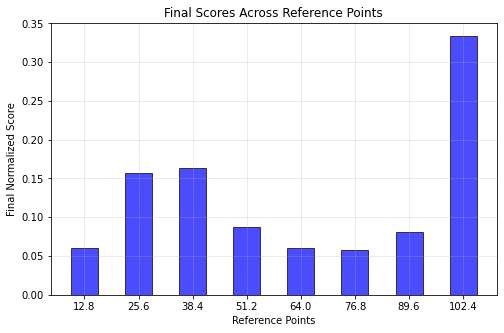

In [4]:
# 按列求和，得到八个参考点的总得分
final_scores = normalized_scores.sum(axis=0)

# 归一化，使得总得分为 1
final_scores /= final_scores.sum()

# 打印归一化后的最终得分
print("Final Normalized Scores for Each Reference Point:")
for i, score in enumerate(final_scores):
    print(f"Point {list_points[i]:.1f}: Score = {score:.4f}")

# 可视化最终得分
plt.figure(figsize=(8, 5))
plt.bar(list_points, final_scores, width=0.05 * L, color='blue', alpha=0.7, edgecolor='k')

plt.xlabel("Reference Points")
plt.ylabel("Final Normalized Score")
plt.title("Final Scores Across Reference Points")
plt.xticks(list_points)
plt.grid(alpha=0.3)
plt.show()


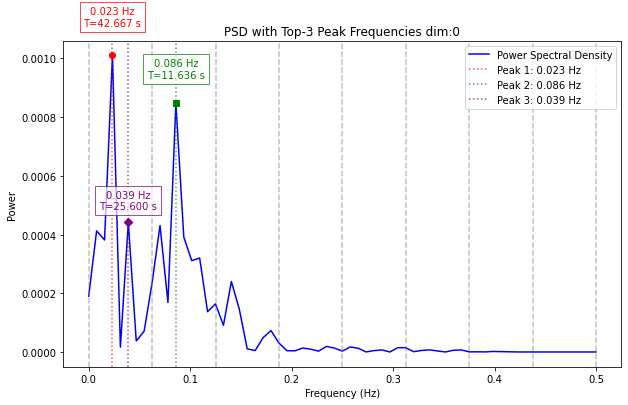

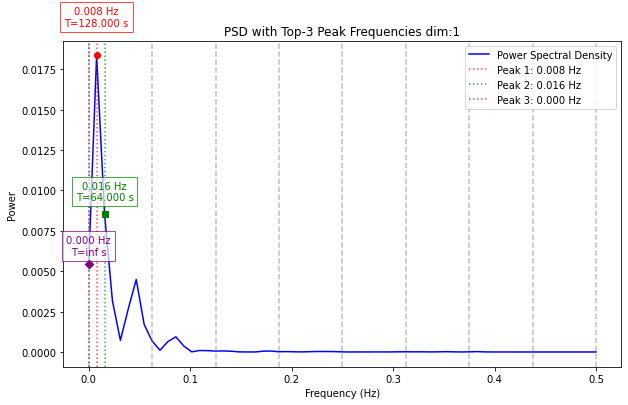

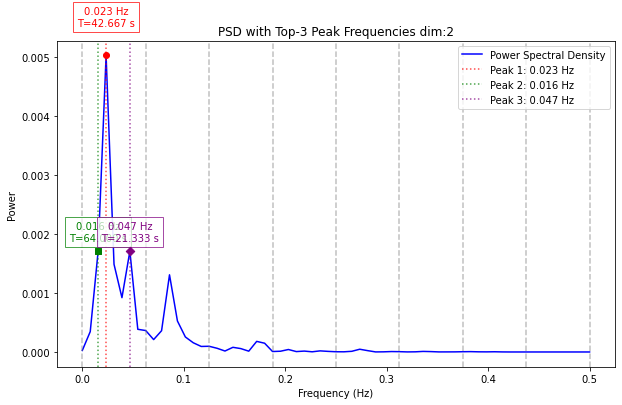

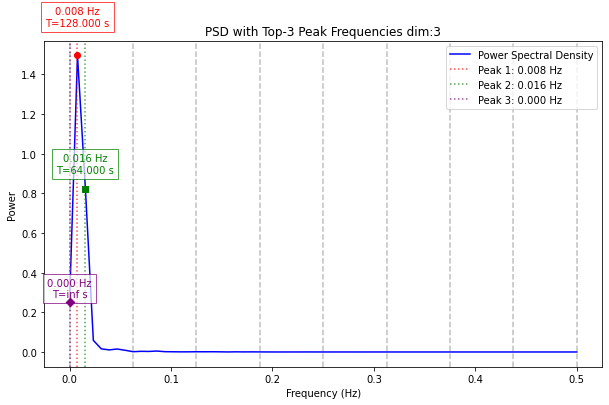

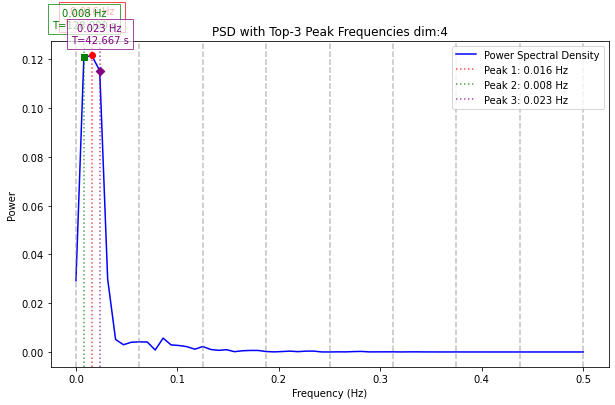

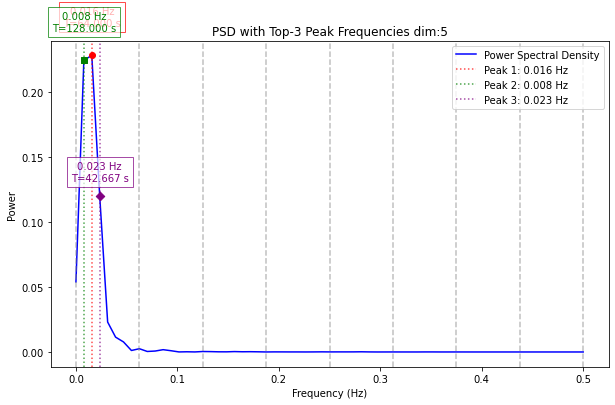

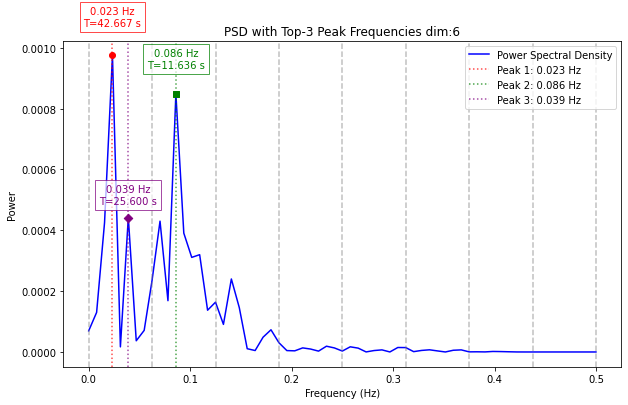

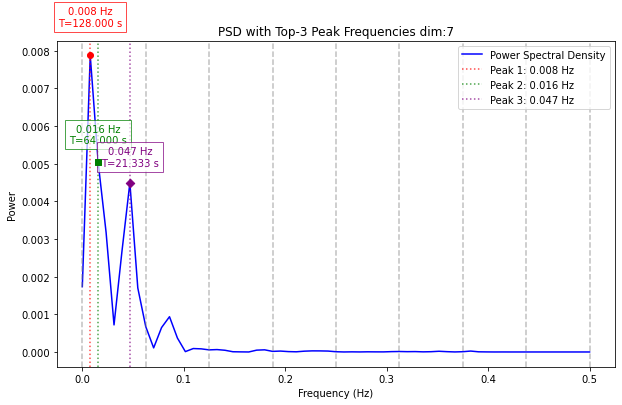

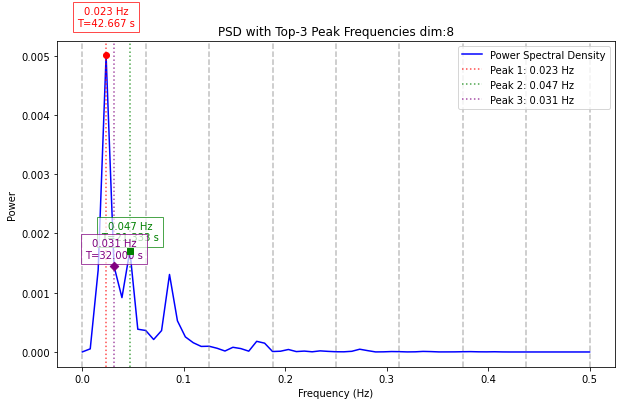

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_psd_with_topk_peaks(time_series, fs=1.0, num_bands=8, top_k=3, filename="psd_plot_topk.png",dim_idx=0):
    """
    绘制时间序列的功率谱密度（PSD），频段划分，并标注Top-K主频（Top-K Peak Frequencies），
    并保存为图片文件。
    """
    # 计算功率谱密度
    frequencies, power_spectrum = welch(time_series, fs=fs, nperseg=len(time_series))
    
    # 确定最大频率
    f_max = frequencies[-1]
    
    # 划分频段
    band_edges = np.linspace(0, f_max, num_bands + 1)
    
    # 找到 Top-K 最高功率的频率索引
    top_k_indices = np.argsort(power_spectrum)[-top_k:][::-1]  # 取最大的K个，并按降序排序
    top_k_frequencies = frequencies[top_k_indices]
    top_k_powers = power_spectrum[top_k_indices]
    top_k_periods = [1 / f if f > 0 else np.inf for f in top_k_frequencies]  # 计算周期

    # 绘制 PSD 曲线
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, power_spectrum, label="Power Spectral Density", color="blue")
    
    # 标记频段划分
    for edge in band_edges:
        plt.axvline(edge, color='gray', linestyle='--', alpha=0.5)
    
    # 标注 Top-K 主频
    colors = ['r', 'g', 'purple', 'orange', 'cyan']  # 颜色列表，支持最多 5 个 Top-K
    markers = ['o', 's', 'D', '^', 'v']  # 形状列表
    for i, (freq, power, period) in enumerate(zip(top_k_frequencies, top_k_powers, top_k_periods)):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        plt.axvline(freq, color=color, linestyle=':', alpha=0.7, label=f"Peak {i+1}: {freq:.3f} Hz")
        plt.scatter(freq, power, color=color, marker=marker, zorder=5)
        plt.text(freq, power * 1.1, f"{freq:.3f} Hz\nT={period:.3f} s", color=color, ha='center',
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor=color))
    
    # 设置标题和标签
    plt.title(f"PSD with Top-{top_k} Peak Frequencies dim:{dim_idx}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    
    # 保存图片
    plt.plot()

def plot_psd_for_all_dimensions(har_data, fs=1.0, num_bands=8, top_k=3, filename_prefix="psd_plot_"):
    """
    为 `har_data` 中的每个样本和每个维度分别绘制功率谱密度图，并标注Top-K主频。
    """
    num_samples, num_dimensions, num_time_steps = har_data.shape
    
    # 遍历每个样本和每个维度进行绘图
    for sample_idx in range(num_samples):
        for dim_idx in range(num_dimensions):
            time_series = har_data[sample_idx, dim_idx, :]
            filename = f"{filename_prefix}sample{sample_idx+1}_dim{dim_idx+1}.png"
            plot_psd_with_topk_peaks(time_series, fs=fs, num_bands=num_bands, top_k=top_k, filename=filename,dim_idx=dim_idx)


# 示例使用：绘制 `har_data[2]` 这个样本的所有维度的 PSD，并标注 Top-3 主频
plot_psd_for_all_dimensions(har_data[3:4], fs=1.0, num_bands=8, top_k=3, filename_prefix="psd_plot_")


Final Normalized Scores for Each Reference Point:
Point 0.1L: Score = 0.1190
Point 0.2L: Score = 0.1500
Point 0.3L: Score = 0.1202
Point 0.4L: Score = 0.0856
Point 0.5L: Score = 0.0675
Point 0.6L: Score = 0.0583
Point 0.7L: Score = 0.0719
Point 0.8L: Score = 0.3275


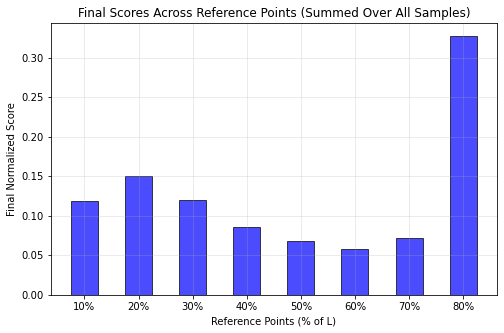

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# 采样率
fs = 1  

# STFT 参数
window_size = None  # 后续根据 L 设置
n_fft = None
hop_size = None

# 目标点
list_points = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # 归一化到 [0,1]

# 选择标准差（sigma）
sigma_ratio = 0.1  # 设为 L 的 10% 作为平滑因子

# 初始化总得分
total_scores = np.zeros(len(list_points))

# 遍历所有 HAR 样本
for sample_idx in range(len(har_data)):  
    sample_data = har_data[sample_idx].T  # 转置为 (L, K)
    L, K = sample_data.shape  # L: 时间步数, K: 维度数
    list_points_scaled = list_points * L  # 按 L 计算真实目标点

    # 重新计算 STFT 相关参数
    window_size = max(4, L // 2)  
    n_fft = 8 * window_size  
    hop_size = window_size // 4  
    sigma = sigma_ratio * L  # 计算标准差

    # 选择前 k 维度
    k = min(9, K)  
    sum_list = []

    for i in range(k):
        # 计算 STFT
        f, _, Zxx = stft(sample_data[:, i], fs=fs, nperseg=window_size, noverlap=window_size - hop_size, nfft=n_fft)

        # 计算功率谱
        power_spectrum = np.abs(Zxx) ** 2

        # 找到功率最大的前 5%
        threshold = np.percentile(power_spectrum, 95)  
        bright_region = power_spectrum >= threshold  

        # 计算加权中心频率
        if np.sum(bright_region) > 0:
            weighted_freq = np.sum(f[:, None] * power_spectrum * bright_region) / np.sum(power_spectrum * bright_region)
        else:
            weighted_freq = 0  # 防止除零

        sum_list.append(weighted_freq)

    # 计算每个维度的评分
    sum_array = np.array(sum_list)
    sum_array = 1 / sum_array  # 取倒数处理
    
    # 计算分数
    scores = np.exp(-((sum_array[:, None] - list_points_scaled[None, :]) ** 2) / (2 * sigma ** 2))

    # 归一化每个维度的得分
    normalized_scores = scores / scores.sum(axis=1, keepdims=True)

    # 叠加所有样本的得分
    total_scores += normalized_scores.sum(axis=0)

# **归一化最终得分**
final_scores = total_scores / total_scores.sum()

# **打印归一化后的最终得分**
print("Final Normalized Scores for Each Reference Point:")
for i, score in enumerate(final_scores):
    print(f"Point {list_points[i]:.1f}L: Score = {score:.4f}")

# **可视化最终得分**
plt.figure(figsize=(8, 5))
plt.bar(list_points * 100, final_scores, width=5, color='blue', alpha=0.7, edgecolor='k')

plt.xlabel("Reference Points (% of L)")
plt.ylabel("Final Normalized Score")
plt.title("Final Scores Across Reference Points (Summed Over All Samples)")
plt.xticks(list_points * 100, labels=[f"{p*100:.0f}%" for p in list_points])
plt.grid(alpha=0.3)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# 输入数据 (假设 har_data 是一个三维数组，形状为 (样本数, 维度数, 时间步长))
# 例如：har_data.shape = (N, K, L)

# 目标点（归一化到 [0,1]）
list_points = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

# 初始化总得分
total_acf_scores = np.zeros(len(list_points))

# 遍历所有 HAR 样本
for sample_idx in range(har_data.shape[0]):  # 遍历样本数 N
    sample_data = har_data[sample_idx]  # 提取单个样本，形状为 (K, L)
    K, L = sample_data.shape  # K: 维度数, L: 时间步长
    list_points_scaled = (list_points * L).astype(int)  # 按 L 计算真实目标点

    # 选择前 k 维度
    k = min(9, K)  # 最多选择 9 个维度
    acf_list = []

    for i in range(k):
        # 计算当前维度的时间序列的 ACF
        time_series = sample_data[i, :]  # 提取第 i 个维度的时间序列
        acf_values = acf(time_series, nlags=L-1, fft=True)  # 使用 FFT 加速计算

        # 提取目标点上的 ACF 值
        acf_at_points = acf_values[list_points_scaled]

        # 保存当前维度的 ACF 值
        acf_list.append(acf_at_points)

    # 将每个维度的 ACF 值转换为 NumPy 数组
    acf_array = np.array(acf_list)

    # 归一化 ACF 值
    normalized_acf = acf_array / acf_array.sum(axis=1, keepdims=True)

    # 叠加所有样本的得分
    total_acf_scores += normalized_acf.sum(axis=0)

# **归一化最终得分**
final_acf_scores = total_acf_scores / total_acf_scores.sum()

# **打印归一化后的最终得分**
print("Final Normalized ACF Scores for Each Reference Point:")
for i, score in enumerate(final_acf_scores):
    print(f"Point {list_points[i]:.1f}L: Score = {score:.4f}")

# **可视化最终得分**
plt.figure(figsize=(8, 5))
plt.bar(list_points * 100, final_acf_scores, width=5, color='green', alpha=0.7, edgecolor='k')

plt.xlabel("Reference Points (% of L)")
plt.ylabel("Final Normalized ACF Score")
plt.title("Final ACF Scores Across Reference Points (Summed Over All Samples)")
plt.xticks(list_points * 100, labels=[f"{p*100:.0f}%" for p in list_points])
plt.grid(alpha=0.3)
plt.show()

ACF + STFT

Final Normalized Scores for Each Reference Point:
Point 0.1L: Score = 0.0965
Point 0.2L: Score = 0.1271
Point 0.3L: Score = 0.1033
Point 0.4L: Score = 0.0730
Point 0.5L: Score = 0.1366
Point 0.6L: Score = 0.1937
Point 0.7L: Score = 0.1742
Point 0.8L: Score = 0.0956


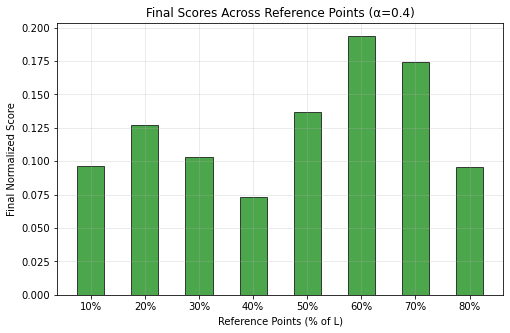

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, find_peaks
from statsmodels.tsa.stattools import acf

# 输入数据 (假设 har_data 是一个三维数组，形状为 (样本数, 维度数, 时间步长))
# 例如：har_data.shape = (N, K, L)

# 调整系数（0 <= alpha <= 1）
# alpha=0.5 表示 STFT 和 ACF 各占 50%
# alpha=0.7 表示 STFT 占 70%，ACF 占 30%
alpha = 0.4  # 用户可根据需求调整

# 目标点（归一化到 [0,1]）
list_points = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

# 初始化总得分
total_scores_stft = np.zeros(len(list_points))  # STFT 得分
total_scores_acf = np.zeros(len(list_points))   # ACF 得分

# ACF 峰值检测门限
acf_threshold = 0.2  # 可根据需要调整

# 遍历所有 HAR 样本
for sample_idx in range(har_data.shape[0]):  # 遍历样本数 N
    sample_data = har_data[sample_idx]  # 提取单个样本，形状为 (K, L)
    K, L = sample_data.shape  # K: 维度数, L: 时间步长
    list_points_scaled = (list_points * L).astype(int)  # 按 L 计算真实目标点

    # 选择前 k 维度
    k = min(9, K)  # 最多选择 9 个维度

    # 1. STFT 分析
    stft_scores = []

    for i in range(k):
        # 重新计算 STFT 相关参数
        window_size = max(4, L // 2)
        n_fft = 8 * window_size
        hop_size = window_size // 4

        # 计算 STFT
        f, _, Zxx = stft(sample_data[i, :], fs=1, nperseg=window_size, noverlap=window_size - hop_size, nfft=n_fft)

        # 计算功率谱
        power_spectrum = np.abs(Zxx) ** 2

        # 找到功率最大的前 5%
        threshold = np.percentile(power_spectrum, 95)
        bright_region = power_spectrum >= threshold

        # 计算加权中心频率
        if np.sum(bright_region) > 0:
            weighted_freq = np.sum(f[:, None] * power_spectrum * bright_region) / np.sum(power_spectrum * bright_region)
        else:
            weighted_freq = 0  # 防止除零

        # 计算当前维度的 STFT 得分
        current_score = 1 / weighted_freq if weighted_freq != 0 else 0
        stft_scores.append(current_score)

    # 转换为数组并计算高斯核得分
    stft_scores = np.array(stft_scores)
    stft_gauss = np.exp(-((stft_scores[:, None] - list_points_scaled) ** 2) / (2 * (L * 0.1) ** 2))
    stft_normalized = stft_gauss / stft_gauss.sum(axis=1, keepdims=True)
    total_scores_stft += stft_normalized.sum(axis=0)  # 累加所有维度的得分

    # 2. ACF 分析
    acf_scores = []

    for i in range(k):
        # 计算当前维度的 ACF
        time_series = sample_data[i, :]
        acf_values = acf(time_series, nlags=L-1, fft=True)
        
        # 找到 lag > L/2 的峰值点
        half_lag = L // 2
        peaks, _ = find_peaks(acf_values[half_lag:], height=acf_threshold)
        peak_lags = peaks + half_lag

        if len(peak_lags) == 0:
            continue

        # 计算每个峰值点与参考点的距离得分
        current_scores = np.zeros(len(list_points))
        for lag in peak_lags:
            distances = np.abs(lag - list_points_scaled)
            current_scores += 1 / (distances + 1e-6)
        
        # 归一化当前维度的得分
        current_scores /= current_scores.sum()
        acf_scores.append(current_scores)

    if acf_scores:
        acf_scores = np.array(acf_scores)
        acf_normalized = acf_scores / acf_scores.sum(axis=1, keepdims=True)
        total_scores_acf += acf_normalized.sum(axis=0)  # 累加所有维度的得分

# 合并得分：前4个用STFT，后4个用ACF，并根据alpha调整权重
stft_part = total_scores_stft[:4]
acf_part = total_scores_acf[4:]

# 归一化各自的得分（防止分母为零）
stft_sum = stft_part.sum()
acf_sum = acf_part.sum()

stft_part_normalized = stft_part / stft_sum if stft_sum != 0 else np.zeros_like(stft_part)
acf_part_normalized = acf_part / acf_sum if acf_sum != 0 else np.zeros_like(acf_part)

# 加权合并并归一化
final_scores = np.concatenate([
    stft_part_normalized * alpha,
    acf_part_normalized * (1 - alpha)
])
final_scores /= final_scores.sum()

# 打印结果
print("Final Normalized Scores for Each Reference Point:")
for i, score in enumerate(final_scores):
    print(f"Point {list_points[i]:.1f}L: Score = {score:.4f}")

# 可视化
plt.figure(figsize=(8, 5))
plt.bar(list_points * 100, final_scores, width=5, color='green', alpha=0.7, edgecolor='k')
plt.xlabel("Reference Points (% of L)")
plt.ylabel("Final Normalized Score")
plt.title("Final Scores Across Reference Points (α={:.1f})".format(alpha))
plt.xticks(list_points * 100, labels=[f"{p*100:.0f}%" for p in list_points])
plt.grid(alpha=0.3)
plt.show()


In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


# 假设 har_data 是一个 numpy 数组 [B, T, C]
print(har_data.shape)

# 转换为 tensor 并转置为 [B, T, C]
x = torch.transpose(torch.tensor(har_data, dtype=torch.float32), 1, 2)

# 获取周期
period= FFT_for_Period(x, k=4)

print(period)

(5881, 9, 128)
(array([ 64,  32,  25, 128]), tensor([[ 0.0517,  0.0524,  0.0530,  0.1859],
        [11.6390, 11.6106,  3.3185,  3.2044],
        [15.0533,  7.4106,  8.5536,  8.0377],
        ...,
        [ 8.7064,  6.6583,  1.8562,  1.5725],
        [ 0.1723,  0.0834,  0.0676,  0.3474],
        [15.1728, 11.0856,  4.5745,  1.2276]]))
